# Synaptic Connections

@[Tianqiu Zhang](mailto:tianqiuakita@gmail.com)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) 

Synaptic connections is an essential part for building a neural dynamic system. BrainPy provides several commonly used connection methods in the [brainpy.connect](../apis/auto/building/connect.rst) module (which can be accessed by the shortcut `bp.conn`) that can help users to easily construct many types of synaptic connection, inclulding built-in and self-customized connectors.

## An Overview of BrainPy Connectors

Here we provide an overview of BrainPy connectors. 

### Base class: `bp.conn.Connector`

The base class of connectors is `brainpy.connect.Connector`. All connectors, built-in or customized, should inherit from the Connector class.

### Two subclasses: `TwoEndConnector` and `OneEndConnector`

There are two classes inheriting from the base class `bp.conn.Connector`:
- [bp.conn.TwoEndConnector](../apis/auto/generated/brainpy.building.connect.TwoEndConnector.rst): a connector to build synaptic connections **between two neuron groups**.
- [bp.conn.OneEndConnector](../apis/auto/generated/brainpy.building.connect.OneEndConnector.rst): a connector to build synaptic connections **within a population of neurons**.

Users can click the link of each class above to look through the API documentation.

### Connector.\_\_init\_\_()

All connectors need to be initialized first. For each built-in connector, users need to pass in the corresponding parameters for initialization. For details, please see the specific conector type below. 

### Connector.\_\_call\_\_()

After initialization, users should call the connector and pass in parameters depending on specific  connection types:
- `TwoEndConnector`: It has two input parameters `pre_size` and `post_size`, each representing the size of the pre- and post-synaptic neuron group. It will result in a connection matrix with the shape of (pre_num, post_num).
- `OneEndConnector`: It has only one parameter `pre_size` which represent the size of the neuron group. It will result in a connection matrix with the shape of (pre_num, pre_num).

The `__call__` function returns the class itself.

### Connector.build_conn()
Users can customize the connection in `build_conn()` function. Notice there are three connection types users can provide:
| Connection Types | Definition |
| :- | :- |
| 'mat' | Dense conncetion, including a connection matrix. |
| 'ij' | Index projection, including a pre-neuron index vector and a post-neuron index vector. |
| 'csr' | Sparse connection, including a index vector and a indptr vector.  |

Return type can be either a `dict` or a `tuple`. Here are two examples of how to return your connection data:

Example 1：
```python
def build_conn(self):
  ind = np.arange(self.pre_num)
  indptr = np.arange(self.pre_num + 1)

  return dict(csr=(ind, indptr), mat=None, ij=None)
```

Example 2:
```python
def build_conn(self):
  ind = np.arange(self.pre_num)
  indptr = np.arange(self.pre_num + 1)

  return 'csr', (ind, indptr)
```

After creating the synaptic connection, users can use the `require()` method to access some useful properties of the connection.

### Connector.require()
This method returns the connection properties required by users. The connection properties are elaborated in the following sections in detail. Here is a brief summary of the connection properties users can require.

| Connection properties | Structure | Definition | 
| :- | :- | :- |
| `conn_mat` | 2-D array (matrix) | Dense connection matrix | 
| `pre_ids` | 1-D array (vector) | Indices of the pre-synaptic neuron group |
| `post_ids` | 1-D array (vector) | Indices of the post-synaptic neuron group |
| `pre2post` | tuple (vector, vector) | The post-synaptic neuron indices and the corresponding pre-synaptic neuron pointers | 
| `post2pre` | tuple (vector, vector) | The pre-synaptic neuron indices and the corresponding post-synaptic neuron pointers |
| `pre2syn` | tuple (vector, vector) | The synapse indices sorted by pre-synaptic neurons and corresponding pre-synaptic neuron pointers | 
| `post2syn` | tuple (vector, vector) | The synapse indices sorted by post-synaptic neurons and corresponding post-synaptic neuron pointers |

Users can implement this method by following sentence:
```python
pre_ids, post_ids, pre2post, conn_mat = conn.require('pre_ids', 'post_ids', 'pre2post', 'conn_mat')
```

```{note}
Note that this method can return multiple connection properties.
```

## Connection Properties

There are multiple connection properties that can be required by users.

### 1. `conn_mat`

The matrix-based synaptic connection is one of the most intuitive ways to build synaptic computations. The connection matrix between two neuron groups can be easily obtained through the function of `connector.requires('conn_mat')`. Each connection matrix is an array with the shape of $(n_{pre}, n_{post})$:

<img src="../_static/syn-example-conn_mat.png" width="400 px">

### 2. `pre_ids` and `post_ids`

Using *vectors* to store the connection between neuron groups is a much more efficient way to reduce memory when the connection matrix is sparse. For the connction matrix `conn_mat` defined above, we can align the connected pre-synaptic neurons and the post-synaptic neurons by two one-dimensional arrays: *pre_ids* and *post_ids*.

<img src="../_static/syn-example-pre_ids-post_ids.png" width="700 px">

In this way, we only need two vectors (`pre_ids` and `post_ids`) to store the synaptic connection. `syn_id` in the figure indicates the indices of each neuron pair, i.e. each synapse.

### 3. `pre2post` and `post2pre`

Another two synaptic structures are `pre2post` and `post2pre`. They establish the mapping between the pre- and post-synaptic neurons.

`pre2post` is a tuple containing two vectors, one of which is the post-synaptic neuron indices and the other is the corresponding pre-synaptic neuron pointers. For example, the following figure shows the indices of the pre-synaptic neurons and the post-synaptic neurons to which the pre-synaptic neurons project:

<img src="../_static/syn-example-pre2post.png" width="300 px">

To record the connection, firstly the post_ids are concatenated as a single vector call the **post-synaptic index vector (indices)**. Because the post-synaptic neuron indices have been sorted by the pre-synaptic neuron indices, it is sufficient to record only the starting position of each pre-synaptic neuron index. Therefore, the pre-synaptic neuron indices and the end of the last pre-synaptic neuron index together make up the **pre-synaptic index pointer vector (indptr)**, which is illustrated in the figure below.

<img src="../_static/syn-example-pre2syn-2.png" width="700 px">

The post-synaptic neuron indices to which pre-synaptic neuron $i$ projects can be obtained by array slicing:

```python
indices[indptr[i], indptr[i+1]]
```

Similarly, `post2pre` is a 2-element tuple containing the pre-synaptic neuron indices and the corresponding post-synaptic neuron pointers. Taking the connection in the illutration aobve as an example, the post-synaptic neuron indices and the pre-synaptic neuron indices to which the post-synaptic neurons project is shown as:

<img src="../_static/syn-example-post2pre.png" width="300 px">

The **pre-synaptic index vector (indices)** and the **post-synaptic index pointer vector (indptr)** are listed below:

<img src="../_static/syn-example-post2syn-2.png" width="700 px">

When the connection is sparse, `pre2post` (or `post2pre`) is a very efficient way to store the connection, since the lengths of the two vectors in the tuple are $n_{synapse}$ and $n_{pre}$ ($n_{post}$), respectively.

### 4. `pre2syn` and `post2syn`

The last two properties are `pre2syn` and `post2syn` that record pre- and post-synaptic projection, respectively. 

For **`pre2syn`**, similar to `pre2post` and `post2pre`, there is a **synapse index vector** and a **pre-synaptic index pointer vector** that refers to the starting position of each pre-synaptic neuron index at the synapse index vector.

Below is the same example identifying the connection by pre-synaptic neuron indices and the synapses belonging to them.

<img src="../_static/syn-example-pre2syn.png" width="300 px">

For better understanding, The synapse indices, pre- and post-synaptic neuron indices are shown as below:

<img src="../_static/syn-example-pre2syn-1.png" width="700 px">

The **pre-synaptic index pointer vector** is computed in the same way as in `pre2post`:

<img src="../_static/syn-example-pre2syn-2.png" width="700 px">

Similarly, **`post2syn`** is a also tuple containing the synapse neuron indices and the corresponding post-synaptic neuron pointers.

<img src="../_static/syn-example-post2syn.png" width="300 px">

The only different from `pre2syn` is that the synapse indices is (most of the time) originally sorted by pre-synaptic neurons, but when computing `post2syn`, synapses should be sorted by post-synaptic neuron indices:

<img src="../_static/syn-example-post2syn-1.png" width="700 px">

The **synapse index vector** (the first row) and the **post-synaptic index pointer vector** (the last row) are listed below:

<img src="../_static/syn-example-post2syn-2.png" width="700 px">

In [44]:
import brainpy as bp
import brainpy.math as bm

# bp.math.set_platform('cpu')

bp.__version__

'2.3.0'

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Built-in regular connections

### brainpy.connect.One2One

The neurons in the pre-synaptic neuron group only connect to the neurons
in the same position of the post-synaptic group. Thus, this connection
requires the indices of two neuron groups same. Otherwise, an error will
occurs.

<img src="../_static/one2one.png" width="200 px">

In [3]:
conn = bp.connect.One2One()
conn(pre_size=10, post_size=10)

One2One

where `pre_size` denotes the size of the pre-synaptic neuron group, `post_size` denotes the size of the post-synaptic neuron group.
Note that parameter `size` can be *int*, *tuple of int* or *list of int* where each element represent each dimension of neuron group.

In One2One connection, particularly, `pre_size` and `post_size` must be the same.

Class `One2One` is inherited from `TwoEndConnector`. Users can use method `require` or `requires` to get specific connection properties.

Here is an example:

In [4]:
size = 5
conn = bp.connect.One2One()(pre_size=size, post_size=size)
res = conn.require('pre_ids', 'post_ids', 'pre2post', 'conn_mat')

print('pre_ids:', res[0])
print('post_ids:', res[1])
print('pre2post:', res[2])

pre_ids: Array([0, 1, 2, 3, 4], dtype=int32)
post_ids: Array([0, 1, 2, 3, 4], dtype=int32)
pre2post: (Array([0, 1, 2, 3, 4], dtype=int32), Array([0, 1, 2, 3, 4, 5], dtype=int32))


### brainpy.connect.All2All

All neurons of the post-synaptic population form connections with all
neurons of the pre-synaptic population (dense connectivity). Users can
choose whether connect the neurons at the same position
(`include_self=True or False`).

<img src="../_static/all2all.png" width="200 px">

In [5]:
conn = bp.connect.All2All(include_self=False)
conn(pre_size=size, post_size=size)

All2All(include_self=False)

Class `All2All` is inherited from `TwoEndConnector`. Users can use method `require` or `requires` to get specific connection properties.

Here is an example:

In [6]:
conn = bp.connect.All2All(include_self=False)(pre_size=size, post_size=size)
res = conn.require('pre_ids', 'post_ids', 'pre2post', 'conn_mat')

print('pre_ids:', res[0])
print('post_ids:', res[1])
print('pre2post:', res[2])
print('conn_mat:', res[3])

pre_ids: Array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4], dtype=int32)
post_ids: Array([1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3], dtype=int32)
pre2post: (Array([1, 2, 3, 4, 0, 2, 3, 4, 4, 3, 1, 0, 0, 1, 2, 4, 0, 1, 2, 3], dtype=int32), Array([ 0,  4,  8, 12, 16, 20], dtype=int32))
conn_mat: Array([[False,  True,  True,  True,  True],
       [ True, False,  True,  True,  True],
       [ True,  True, False,  True,  True],
       [ True,  True,  True, False,  True],
       [ True,  True,  True,  True, False]], dtype=bool)


### brainpy.connect.GridFour

`GridFour` is the four nearest neighbors connection. Each neuron connect to its
nearest four neurons.

<img src="../_static/grid_four.png" width="250 px">

In [7]:
conn = bp.connect.GridFour(include_self=False)
conn(pre_size=size)

GridFour(include_self=False, periodic_boundary=False)

Class `GridFour` is inherited from `OneEndConnector`, therefore there is only one parameter `pre_size` representing the size of neuron group, which should be **two-dimensional geometry**.

Here is an example:

In [8]:
size = (4, 4)
conn = bp.connect.GridFour(include_self=False)(pre_size=size)
res = conn.require('pre_ids', 'conn_mat')

print('pre_ids', res[0])

pre_ids Array([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  5,
        6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10,
       10, 11, 11, 11, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15],      dtype=int32)


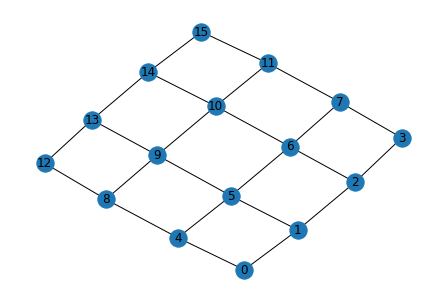

In [9]:
# Using NetworkX to visualize network connection
G = nx.from_numpy_matrix(res[1])
nx.draw(G, with_labels=True)
plt.show()

### brainpy.connect.GridEight

`GridEight` is eight nearest neighbors connection. Each neuron connect to its
nearest eight neurons.

<img src="../_static/grid_eight.png" width="250 px">

In [10]:
conn = bp.connect.GridEight(include_self=False)
conn(pre_size=size)

GridEight(N=1, include_self=False, periodic_boundary=False)

Class `GridEight` is inherited from `GridN`, which will be introduced as followed.

Here is an example:

In [11]:
size = (4, 4)
conn = bp.connect.GridEight(include_self=False)(pre_size=size)
res = conn.require('pre_ids', 'conn_mat')

print('pre_ids', res[0])

pre_ids Array([ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
       12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15],      dtype=int32)


Take the central point (id = 4) as an example, its neighbors are all the other point except itself.
Therefore, its row in `conn_mat` has `True` for all values except itself.

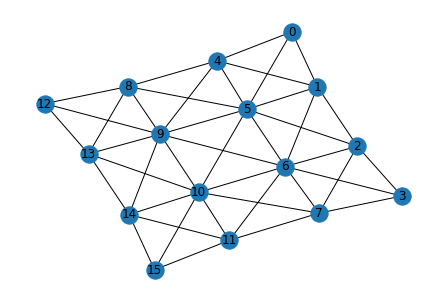

In [12]:
# Using NetworkX to visualize network connection
G = nx.from_numpy_matrix(res[1])
nx.draw(G, with_labels=True)
plt.show()

### brainpy.connect.GridN

`GridN` is also a nearest neighbors connection. Each neuron connect to its
nearest $(2N+1) \cdot (2N+1)$ neurons (if including itself).

<img src="../_static/grid_N.png" width="250 px" >

Here are some examples to fully understand `GridN`. It is slightly different from `GridEight`: `GridEight` is equivalent to `GridN` when N = 1.

- When N = 1:
    $\begin{bmatrix}
    x & x & x\\
    x & I & x\\
    x & x & x
    \end{bmatrix}$

- When N = 2:
    $ \begin{bmatrix}
    x & x & x & x & x\\
    x & x & x & x & x\\
    x & x & I & x & x\\
    x & x & x & x & x\\
    x & x & x & x & x
    \end{bmatrix} $

In [13]:
conn = bp.connect.GridN(N=2, include_self=False)
conn(pre_size=size)

GridN(N=2, include_self=False, periodic_boundary=False)

Here is an example:

In [14]:
size = (4, 4)
conn = bp.connect.GridN(N=1, include_self=False)(pre_size=size)
res = conn.require('conn_mat')

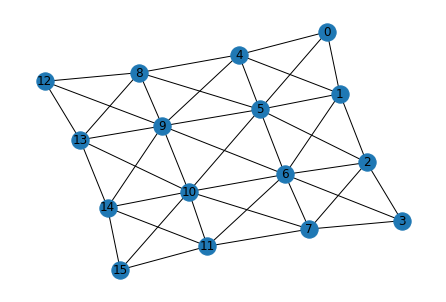

In [15]:
# Using NetworkX to visualize network connection
G = nx.from_numpy_matrix(res)
nx.draw(G, with_labels=True)
plt.show()

## Built-in random connections

### brainpy.connect.FixedProb

For each post-synaptic neuron, there is a fixed probability that it forms a connection
with a neuron of the pre-synaptic population. It is basically a all_to_all projection,
except some synapses are not created, making the projection sparser.

<img src="../_static/fixed_proab.png" width="200 px" >

Class `brainpy.connect.FixedProb` is inherited from `TwoEndConnector`, and it receives three settings:
- `prob`: Fixed probability for connection with a pre-synaptic neuron for each post-synaptic neuron.
- `include_self`: Whether connect to inself.
- `seed`: Seed the random generator.

And there are two parameters passed in for calling instance of class: `pre_size` and `post_size`.

In [16]:
conn = bp.connect.FixedProb(prob=0.5, include_self=False, seed=134)
conn(pre_size=4, post_size=4)
conn.require('conn_mat')

Array([[False,  True,  True,  True],
       [False, False,  True,  True],
       [False,  True, False, False],
       [ True, False, False, False]], dtype=bool)

### brainpy.connect.FixedPreNum

Each neuron in the post-synaptic population receives connections from a
fixed number of neurons of the pre-synaptic population chosen randomly.
It may happen that two post-synaptic neurons are connected to the same
pre-synaptic neuron and that some pre-synaptic neurons are connected to
nothing.

<img src="../_static/fixed_pre_num.png" width="200 px">

Class `brainpy.connect.FixedPreNum` is inherited from `TwoEndConnector`, and it receives three settings:
- `num`: The conn probability (if "num" is float) or the fixed number of connectivity (if "num" is int).
- `include_self`: Whether connect to inself.
- `seed`: Seed the random generator.

And there are two parameters passed in for calling instance of class: `pre_size` and `post_size`.

In [17]:
conn = bp.connect.FixedPreNum(num=2, include_self=True, seed=1234)
conn(pre_size=4, post_size=4)
conn.require('conn_mat')

Array([[ True,  True, False, False],
       [False,  True, False,  True],
       [ True, False,  True, False],
       [False, False,  True,  True]], dtype=bool)

### brainpy.connect.FixedPostNum

Each neuron in the pre-synaptic population sends a connection to a fixed number of neurons
of the post-synaptic population chosen randomly. It may happen that two pre-synaptic neurons
are connected to the same post-synaptic neuron and that some post-synaptic neurons receive
no connection at all.

<img src="../_static/fixed_post_num.png" width="200 px">

Class `brainpy.connect.FixedPostNum` is inherited from `TwoEndConnector`, and it receives three settings:
- `num`: The conn probability (if "num" is float) or the fixed number of connectivity (if "num" is int).
- `include_self`: Whether connect to inself.
- `seed`: Seed the random generator.

And there are two parameters passed in for calling instance of class: `pre_size` and `post_size`.

In [18]:
conn = bp.connect.FixedPostNum(num=2, include_self=True, seed=1234)
conn(pre_size=4, post_size=4)
conn.require('conn_mat')

Array([[ True, False,  True, False],
       [ True,  True, False, False],
       [False, False,  True,  True],
       [False,  True, False,  True]], dtype=bool)

### brainpy.connect.GaussianProb


Builds a Gaussian connection pattern between the two populations, where
the connection probability decay according to the gaussian function.

Specifically,

$$
p=\exp\left(-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma^2}\right)
$$

where $(x, y)$ is the position of the pre-synaptic neuron
and $(x_c,y_c)$ is the position of the post-synaptic neuron.

For example, in a $30 \textrm{x} 30$ two-dimensional networks, when
$\beta = \frac{1}{2\sigma^2} = 0.1$, the connection pattern is shown
as the follows:

<img src="../_static/gaussian_prob.png" width="500 px">

`GaussianProb` is inherited from `OneEndConnector`, and it receives four settings:

- `sigma`: (float) Width of the Gaussian function.
- `encoding_values`: (optional, list, tuple, int, float) The value ranges to encode for neurons at each axis.
- `periodic_boundary` : (bool) Whether the neuron encode the value space with the periodic boundary.
- `normalize`: (bool) Whether normalize the connection probability.
- `include_self` : (bool) Whether create the conn at the same position.
- `seed`: (bool) The random seed.

In [19]:
conn = bp.connect.GaussianProb(sigma=2, periodic_boundary=True, normalize=True, include_self=True, seed=21)
conn(pre_size=10)
conn.require('conn_mat')

Array([[ True,  True, False,  True, False, False, False, False,  True,
         True],
       [ True,  True,  True,  True, False, False, False, False, False,
         True],
       [ True,  True,  True,  True, False, False, False, False, False,
         True],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [False, False, False,  True,  True,  True, False, False, False,
        False],
       [False, False,  True, False,  True,  True,  True,  True, False,
        False],
       [False, False, False,  True, False,  True,  True,  True, False,
        False],
       [ True, False, False, False, False,  True,  True,  True, False,
         True],
       [False,  True, False, False, False, False,  True,  True,  True,
         True],
       [ True, False,  True, False, False,  True, False,  True,  True,
         True]], dtype=bool)

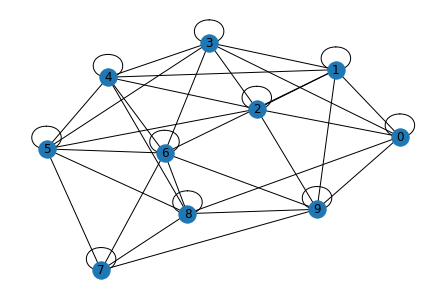

In [20]:
# Using NetworkX to visualize network connection
G = nx.from_numpy_matrix(conn.require('conn_mat'))
nx.draw(G, with_labels=True)
plt.show()

### brainpy.connect.SmallWorld

`SmallWorld` is a connector class to help build a [small-world network](https://en.wikipedia.org/wiki/Small-world_network) [1].  small-world network is defined to be a network where the typical distance L between two randomly chosen nodes (the number of steps required) grows proportionally to the logarithm of the number of nodes N in the network, that is:

$$
L\propto \log N
$$

[1] Duncan J. Watts and Steven H. Strogatz, Collective dynamics of small-world networks, Nature, 393, pp. 440–442, 1998.

Currently, `SmallWorld` only support a one-dimensional network with the ring structure. It receives four settings:

- `num_neighbor`: the number of the nearest neighbors to connect.
- `prob`: the probability of rewiring each edge.
- `directed`: whether the edge is the directed ("directed=True") or undirected ("directed=False") connection.
- `include_self`: whether allow to connect to itself.

In [21]:
conn = bp.connect.SmallWorld(num_neighbor=5, prob=0.2, directed=False, include_self=False)
conn(pre_size=10, post_size=10)
conn.require('conn_mat')

Array([[False,  True,  True, False, False, False, False, False,  True,
         True],
       [ True, False,  True, False, False, False,  True, False, False,
         True],
       [ True,  True, False,  True,  True, False,  True, False, False,
        False],
       [False, False,  True, False,  True,  True,  True, False, False,
        False],
       [False, False,  True,  True, False, False,  True, False, False,
        False],
       [False, False, False,  True, False, False,  True,  True, False,
        False],
       [False,  True,  True,  True,  True,  True, False, False,  True,
        False],
       [False, False, False, False, False,  True, False, False,  True,
         True],
       [ True, False, False, False, False, False,  True,  True, False,
         True],
       [ True,  True, False, False, False, False, False,  True,  True,
        False]], dtype=bool)

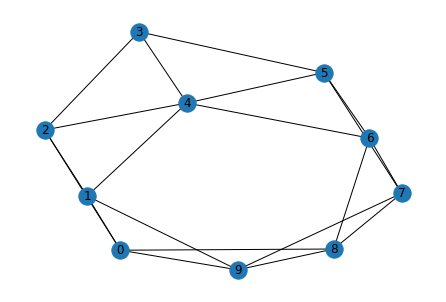

In [22]:
# Using NetworkX to visualize network connection
G = nx.from_numpy_matrix(conn.require('conn_mat'))
nx.draw(G, with_labels=True)
plt.show()

### brainpy.connect.ScaleFreeBA

`ScaleFreeBA` is a connector class to help build a random scale-free network according to the [Barabási–Albert preferential attachment model](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) [2]. `ScaleFreeBA` receives the following settings:

- `m`: Number of edges to attach from a new node to existing nodes.
- `directed`: whether the edge is the directed ("directed=True") or undirected ("directed=False") connection.
- `seed`: Indicator of random number generation state.

[2] A. L. Barabási and R. Albert “Emergence of scaling in random networks”, Science 286, pp 509-512, 1999.

In [23]:
conn = bp.connect.ScaleFreeBA(m=5, directed=False, seed=12345)
conn(pre_size=10, post_size=10)
conn.require('conn_mat')

Array([[False, False, False, False, False,  True,  True, False, False,
        False],
       [False, False, False, False, False,  True,  True,  True, False,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False,  True, False,  True,  True,
         True],
       [False,  True,  True,  True, False,  True,  True, False,  True,
         True],
       [False, False,  True,  True, False,  True,  True,  True, False,
        False],
       [False,  True, False,  True, False,  True,  True,  True, False,
        False]], dtype=bool)

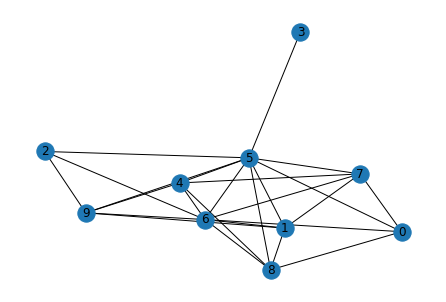

In [24]:
# Using NetworkX to visualize network connection
G = nx.from_numpy_matrix(conn.require('conn_mat'))
nx.draw(G, with_labels=True)
plt.show()

### brainpy.connect.ScaleFreeBADual

`ScaleFreeBADual` is a connector class to help build a random scale-free network according to the dual Barabási–Albert preferential attachment model [3]. ScaleFreeBA receives the following settings:

- `p`: The probability of attaching $m_1$ edges (as opposed to $m_2$ edges).
- `m1` : Number of edges to attach from a new node to existing nodes with probability $p$.
- `m2`: Number of edges to attach from a new node to existing nodes with probability $1-p$.   
- `directed`: whether the edge is the directed ("directed=True") or undirected ("directed=False") connection.
- `seed`: Indicator of random number generation state.

[3] N. Moshiri. "The dual-Barabasi-Albert model", arXiv:1810.10538.

In [25]:
conn = bp.connect.ScaleFreeBADual(m1=3, m2=5, p=0.5, directed=False, seed=12345)
conn(pre_size=10, post_size=10)
conn.require('conn_mat')

Array([[False, False, False, False, False,  True,  True,  True, False,
         True],
       [False, False, False, False, False,  True, False,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True, False, False, False,  True,  True,  True,
         True],
       [ True, False,  True, False, False,  True, False,  True,  True,
         True],
       [ True,  True,  True, False, False,  True,  True, False,  True,
         True],
       [False,  True,  True, False, False,  True,  True,  True, False,
        False],
       [ True, False,  True, False, False,  True,  True,  True, False,
        False]], dtype=bool)

### brainpy.connect.PowerLaw

`PowerLaw` is a connector class to help build a random graph with powerlaw degree distribution and approximate average clustering [4]. It receives the following settings:

- `m` : the number of random edges to add for each new node
- `p` : Probability of adding a triangle after adding a random edge
- `directed`: whether the edge is the directed ("directed=True") or undirected ("directed=False") connection.
- `seed` : Indicator of random number generation state.

[4] P. Holme and B. J. Kim, “Growing scale-free networks with tunable clustering”, Phys. Rev. E, 65, 026107, 2002.

In [26]:
conn = bp.connect.PowerLaw(m=3, p=0.5, directed=False, seed=12345)
conn(pre_size=10, post_size=10)
conn.require('conn_mat')

Array([[False, False, False,  True,  True, False,  True,  True,  True,
        False],
       [False, False, False,  True, False,  True, False, False, False,
        False],
       [False, False, False,  True,  True,  True,  True,  True, False,
         True],
       [ True,  True,  True, False,  True, False, False, False, False,
        False],
       [ True, False,  True,  True, False,  True, False, False,  True,
        False],
       [False,  True,  True, False,  True, False,  True,  True, False,
         True],
       [ True, False,  True, False, False,  True, False, False,  True,
        False],
       [ True, False,  True, False, False,  True, False, False, False,
         True],
       [ True, False, False, False,  True, False,  True, False, False,
        False],
       [False, False,  True, False, False,  True, False,  True, False,
        False]], dtype=bool)

## Encapsulate your existing connections

BrainPy also allows users to encapsulate existing connections with convenient class interfaces. Users can provide connection types as:
- Index projection;
- Dense matrix;
- Sparse matrix.

Then users should provide `pre_size` and `post_size` information in order to instantiate the connection. In such a way, based on the following connection classes, users can generate any other synaptic structures (such like `pre2post`, `pre2syn`, `conn_mat`, etc.) easily.

### `bp.conn.IJConn`

Here, let’s take a simple connection as an example. In this example, we create a connection which receives users’ handful index projection by using `bp.conn.IJConn`.

In [27]:
pre_list = np.array([0, 1, 2])
post_list = np.array(([0, 0, 0]))
conn = bp.conn.IJConn(i=pre_list, j=post_list)
conn = conn(pre_size=5, post_size=3)

In [28]:
conn.requires('conn_mat')

Array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False, False],
       [False, False, False]], dtype=bool)

In [29]:
conn.requires('pre2post')

C:\Users\adadu\miniconda3\envs\brainpy\lib\site-packages\jax\_src\ops\scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


(Array([0, 0, 0], dtype=int32), Array([0, 1, 2, 3, 3, 3], dtype=int32))

In [30]:
conn.requires('pre2syn')

(Array([0, 1, 2], dtype=int32), Array([0, 1, 2, 3, 3, 3], dtype=int32))

### `bp.conn.MatConn`

In next example, we create a connection which receives user's handful dense connection matrix by using `bp.conn.MatConn`.

In [31]:
bp.math.random.seed(123)
conn = bp.connect.MatConn(conn_mat=np.random.randint(2, size=(5, 3), dtype=bp.math.bool_))
conn = conn(pre_size=5, post_size=3)

In [32]:
conn.requires('conn_mat')

Array([[False,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [False,  True,  True],
       [False, False,  True]], dtype=bool)

In [33]:
conn.requires('pre2post')

C:\Users\adadu\miniconda3\envs\brainpy\lib\site-packages\jax\_src\ops\scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


(Array([1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2], dtype=int32),
 Array([ 0,  2,  5,  8, 10, 11], dtype=int32))

In [34]:
conn.require('pre2syn')

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 Array([ 0,  2,  5,  8, 10, 11], dtype=int32))

### `bp.conn.SparseMatConn`

In last example, we create a connection which receives user's handful sparse connection matrix by using `bp.conn.sparseMatConn`

In [35]:
from scipy.sparse import csr_matrix

conn_mat = np.random.randint(2, size=(5, 3), dtype=bp.math.bool_)
sparse_mat = csr_matrix(conn_mat)
conn = bp.conn.SparseMatConn(sparse_mat)
conn = conn(pre_size=sparse_mat.shape[0], post_size=sparse_mat.shape[1])

In [36]:
conn.requires('conn_mat')

Array([[ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [False,  True,  True],
       [ True,  True, False]], dtype=bool)

In [37]:
conn.requires('pre2post')

(Array([0, 2, 0, 2, 0, 2, 1, 2, 0, 1], dtype=int32),
 Array([ 0,  2,  4,  6,  8, 10], dtype=int32))

In [38]:
conn.requires('post2syn')

(Array([0, 2, 4, 8, 6, 9, 1, 3, 5, 7], dtype=int32),
 Array([ 0,  4,  6, 10], dtype=int32))

### Using NetworkX to provide connections and pass into `Connector`

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

Users can design their own complex netork by using `NetworkX`.


In [39]:
import networkx as nx
G = nx.Graph()

By definition, a `Graph` is a collection of nodes (vertices) along with identified pairs of nodes (called edges, links, etc).

To learn more about `NetowrkX`, please check the official documentation: [NetworkX tutorial](https://networkx.org/documentation/stable/tutorial.html)

Using class [`brainpy.connect.MatConn`](https://brainpy.readthedocs.io/en/latest/apis/simulation/generated/brainpy.simulation.connect.MatConn.html) to construct connections is recommended here.
- Dense adjacency matrix: a two-dimensional ndarray.

Here gives an example to illustrate how to transform a random graph into your synaptic connections by using dense adjacency matrix.

dense adjacency matrix:
[[0 1 1 0 1]
 [1 0 1 0 0]
 [1 1 0 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]]


C:\Users\adadu\AppData\Local\Temp\ipykernel_2488\2020588093.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  B = nx.adjacency_matrix(G)
C:\Users\adadu\AppData\Local\Temp\ipykernel_2488\2020588093.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense()) # get dense adjacency matrix of G


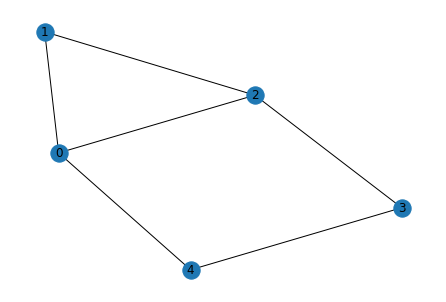

In [40]:
G = nx.fast_gnp_random_graph(5, 0.5) # initialize a random graph G
B = nx.adjacency_matrix(G)
A = np.array(nx.adjacency_matrix(G).todense()) # get dense adjacency matrix of G

print('dense adjacency matrix:')
print(A)
nx.draw(G, with_labels=True)
plt.show()

Users can use class `MatConn` inherited from `TwoEndConnector` to construct connections. **A dense adjacency matrix** should be passed in when initializing `MatConn` class.
Note that when calling the instance of the class, users should pass in two parameters: `pre_size` and `post_size`.
In this case, users can use the shape of dense adjacency matrix as the parameters.

In [41]:
conn = bp.connect.MatConn(A)(pre_size=A.shape[0], post_size=A.shape[1])
res = conn.require('conn_mat')

print(res)

Array([[False,  True,  True, False,  True],
       [ True, False,  True, False, False],
       [ True,  True, False,  True, False],
       [False, False,  True, False,  True],
       [ True, False, False,  True, False]], dtype=bool)


## Customize your connections

BrainPy allows users to customize their connections. The following requirements should be satisfied:

- Your connection class should inherit from `brainpy.connect.TwoEndConnector` or `brainpy.connect.OneEndConnector`.
- `__init__` function should be implemented and essential parameters should be initialized.
- Users should also overwrite `build_csr()`, `build_coo()` or `build_mat()` function to describe how to build your connection.

Let's take an example to illustrate the details of customization.

In [42]:
class FixedProb(bp.connect.TwoEndConnector):
  """Connect the post-synaptic neurons with fixed probability.

  Parameters
  ----------
  prob : float
      The conn probability.
  include_self : bool
      Whether to create (i, i) connection.
  seed : optional, int
      Seed the random generator.
  """

  def __init__(self, prob, include_self=True, seed=None):
    super(FixedProb, self).__init__()
    assert 0. <= prob <= 1.
    self.prob = prob
    self.include_self = include_self
    self.seed = seed
    self.rng = np.random.RandomState(seed=seed)

  def build_csr(self):
    ind = []
    count = np.zeros(self.pre_num, dtype=np.uint32)

    def _random_prob_conn(rng, pre_i, num_post, prob, include_self):
      p = rng.random(num_post) <= prob
      if (not include_self) and pre_i < num_post:
        p[pre_i] = False
      conn_j = np.asarray(np.where(p)[0], dtype=np.uint32)
      return conn_j

    for i in range(self.pre_num):
      posts = _random_prob_conn(self.rng, pre_i=i, num_post=self.post_num,
                                prob=self.prob, include_self=self.include_self)
      ind.append(posts)
      count[i] = len(posts)

    ind = np.concatenate(ind)
    indptr = np.concatenate(([0], count)).cumsum()

    return ind, indptr

Then users can initialize the your own connections as below:

In [43]:
conn = FixedProb(prob=0.5, include_self=True)(pre_size=5, post_size=5)
conn.require('conn_mat')

Array([[False,  True, False,  True,  True],
       [ True, False,  True,  True,  True],
       [False,  True, False, False, False],
       [ True, False, False,  True, False],
       [ True,  True, False, False, False]], dtype=bool)